In [1]:
# Usage guide:

# This document is not kept on record. If the calcualtions are to be kept,
# copy the whole notebook and put it in "quick_calculations" or appropriate
# folders.

In [2]:
# import all the E9 stuff
import logging
import numpy as np
import matplotlib.pyplot as plt
import sys
from pathlib import Path

# User defined modules
E9path = Path("C:/", "Users", "ken92", "Documents", "Studies", "E5", "simulation", "E9_simulations")
if str(E9path) not in sys.path:
    sys.path.insert(1, str(E9path))
import E9_fn.E9_constants as E9c
import E9_fn.E9_atom as E9a
import E9_fn.E9_cooltrap as E9ct
# import E9_fn.polarizabilities_calculation as E9pol
# import E9_fn.datasets.transition_line_data as TLData
from E9_fn import util

# Logging
logpath = '' # '' if not logging to a file
loglevel = logging.INFO
logroot = logging.getLogger()
list(map(logroot.removeHandler, logroot.handlers))
list(map(logroot.removeFilter, logroot.filters))
logging.basicConfig(filename = logpath, level = loglevel)

c:\Users\ken92\Documents\Studies\E5\simulation\E9_simulations\.venv\Lib\site-packages\gftool\precision.py:16: UserWarning: No quad precision datatypes available!
Some functions might be less accurate.
  warnings.warn("No quad precision datatypes available!\n"


<Axes: title={'center': '$\\Delta E \\equiv E_{m_F} - E_{m_F - 1}$; avg2zero = False, tolerance = 0.0000 MHz'}, xlabel='B [G]', ylabel='$\\Delta$E/h [MHz]'>

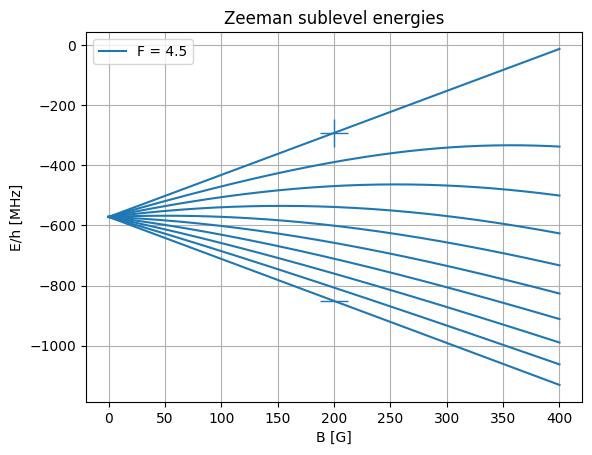

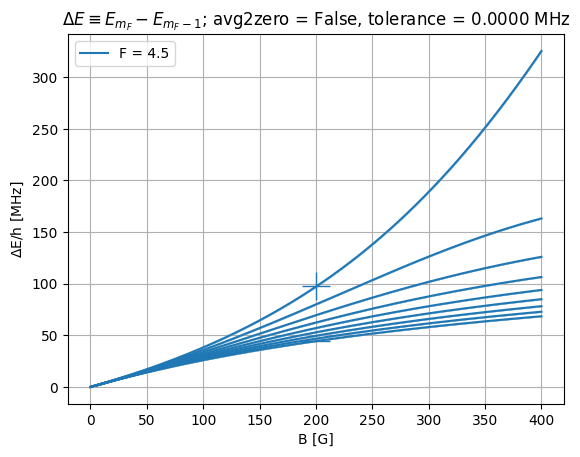

In [7]:
E9a.K40_4_2S1o2_F9o2.PlotBreitRabi(Bmax = 400)
E9a.K40_4_2S1o2_F9o2.PlotBreitRabiDiff(Bmax = 400)

<Axes: title={'center': '$\\Delta E \\equiv E_{m_F} - E_{m_F - 1}$; avg2zero = True, tolerance = 0.0000 MHz'}, xlabel='B [G]', ylabel='$\\Delta$E/h [MHz]'>

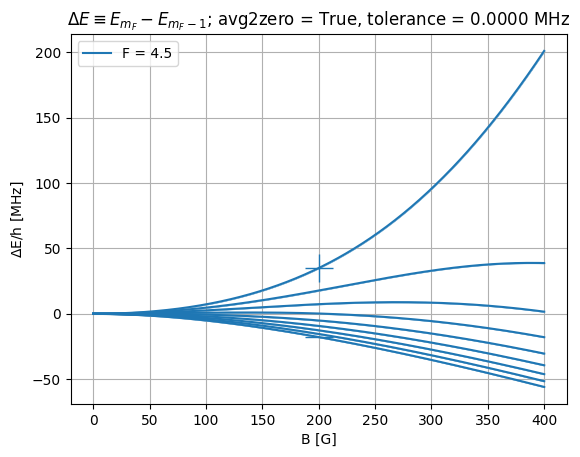

In [6]:
E9a.K40_4_2S1o2_F9o2.PlotBreitRabiDiff(Bmax = 400, avg2zero = True)